In [2]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

warnings.simplefilter(action='ignore', category=FutureWarning)

2024-05-19 21:35:48.706641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 21:35:48.706813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 21:35:48.740067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 21:35:48.815568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:35:50.760124: W tensorflow/compiler/tf2

In [3]:
df = pd.read_pickle("data/data_original.pkl")

down_sample_percentage = 0.01

# down sample data
df = df.sample(frac=down_sample_percentage/100, random_state=1)

# rename emotions to label and map to integers
df.rename(columns={'emotions':'label'}, inplace = True)
label_map = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5} 
df['label'] = df['label'].map(label_map)

print(df.shape)
df.head()

(42, 2)


,text,label
98790,i wanted them to feel now i feel as though i a...,0
18398,i found myself feeling very sympathetic toward...,2
139349,ive been feeling pretty good today and tonight...,1
13416,i can use to cover my ass when i feel inadequate,0
22297,i feel like ive pissed myself again,3


In [4]:
generator = pipeline('text-generation', model='microsoft/Phi-3-mini-128k-instruct', trust_remote_code=True)
set_seed(42)
""" 
# using prompt engineering to generate a template for the model to fill in with the predicted emotion
def guessEmotion(phrase):
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    
    # Initialize the generator with pad_token_id set to eos_token_id to suppress the warning
    generator = pipeline('text-generation', model='gpt2', pad_token_id=50256)
    set_seed(42)
    
    examples = [
        ("This is such a frustrating day", "anger"),
        ("I am so scared of the dark", "fear"),
        ("I am so happy today", "joy"),
        ("He is the love of my life", "love"),
        ("Yesterday was a pretty bad day because my cat died", "sadness"),
        ("I can't believe my eyes", "surprise")
    ]
    
    # Create the template with examples
    template = "Of the 6 emotions (sadness, joy, love, anger, fear, surprise), identify the most prevalent one in each of the following sentences:\n"
    for (example, emotion) in examples:
        template += f"{example}: {emotion}\n"
    template += f"{phrase}:"
    
    # Generate the response with adjusted parameters
    generated_text = generator(template, max_new_tokens=1, num_return_sequences=1, temperature=0.8, top_p=0.9)[0]['generated_text']
    
    # Analyze the generated text to determine the predicted emotion
    response = generated_text[len(template):].strip().lower()
    for emotion in emotions:
        if emotion in response:
            return emotion
    
    return "Unknown"

def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show() """


`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

: 

In [52]:
df['predicted'] = df['text'].apply(guessEmotion)

In [53]:
print(f"Number of 'Unknown' predictions: {df[df['predicted'] == 'Unknown'].shape[0]}")

Number of 'Unknown' predictions: 41


In [54]:
df.head(20)

,text,label,predicted
98790,i wanted them to feel now i feel as though i a...,0,Unknown
18398,i found myself feeling very sympathetic toward...,2,Unknown
139349,ive been feeling pretty good today and tonight...,1,Unknown
13416,i can use to cover my ass when i feel inadequate,0,Unknown
22297,i feel like ive pissed myself again,3,Unknown
13762,i feel a little rebellious,3,Unknown
85074,i have found myself increasingly down and not ...,1,Unknown
16669,i decided to put together a quick post today t...,0,Unknown
80066,i like to pray a decade whenever im feeling st...,0,Unknown
18670,i could be feeling this unease from a sense of...,1,Unknown


In [55]:
# add unknown to label_map
label_map["Unknown"] = 6
df['predicted'] = df['predicted'].map(label_map)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1: 0.0


/home/m/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/m/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


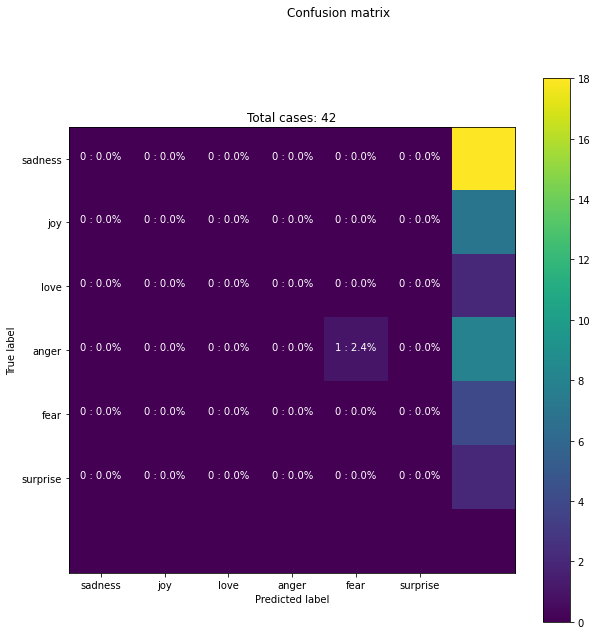

In [56]:
# compare predicted and true labels, calculate accuracy, precision, recall, f1 and confusion matrix
accuracy = accuracy_score(df['label'], df['predicted'])
precision = precision_score(df['label'], df['predicted'], average='macro')
recall = recall_score(df['label'], df['predicted'], average='macro')
f1 = f1_score(df['label'], df['predicted'], average='macro')
confusion = confusion_matrix(df['label'], df['predicted'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
show_cm(confusion, ["sadness", "joy", "love", "anger", "fear", "surprise"])